In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import tensorflow as tf 
import numpy as np
import tensorflow_datasets as tfds
import time

import image_utils
import shap

In [3]:
from attributionpriors import plot, ops

In [4]:
num_epochs = 30
batch_size = 50
train_size = 60000
total_iters = int(train_size / batch_size) * num_epochs
learning_rate = 0.0001

In [5]:
train_set = tfds.load(name='mnist', split=tfds.Split.TRAIN)
train_set = train_set.map(image_utils.normalize).map(image_utils.augment)
train_set = train_set.shuffle(1024).batch(batch_size).repeat(num_epochs).prefetch(tf.data.experimental.AUTOTUNE)
train_iter = train_set.make_initializable_iterator()

test_set  = tfds.load(name='mnist', split=tfds.Split.TEST)
test_set  = test_set.map(image_utils.normalize).batch(batch_size)
test_iter = test_set.make_initializable_iterator()

In [6]:
handle   = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(
    handle, train_set.output_types, train_set.output_shapes)
dict_op  = iterator.get_next()
image_op = dict_op['image']
label_op = dict_op['label']

In [7]:
is_training = tf.placeholder_with_default(False, ())
logit_op = image_utils.model(image_op, is_training)

In [8]:
learning_rate = image_utils.get_learning_rate(learning_rate, batch_size)
global_step = tf.train.get_or_create_global_step()
optimizer = tf.train.AdamOptimizer(learning_rate)

In [9]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_op, logits=logit_op))
train_loss_op = optimizer.minimize(loss, global_step=global_step)

In [10]:
pred_op = tf.argmax(logit_op, 1)
accuracy_op, accuracy_update_op = tf.metrics.accuracy(pred_op, label_op)
reset_metrics_op = tf.variables_initializer(tf.get_collection(tf.GraphKeys.METRIC_VARIABLES))

In [11]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [12]:
train_handle, test_handle = sess.run([train_iter.string_handle(), test_iter.string_handle()])
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [13]:
def train():
    sess.run([init, train_iter.initializer])
    start = time.time()
    while True:
        try:
            i, _ = sess.run([global_step, train_loss_op], feed_dict={handle: train_handle, is_training: True})
            if i % 100 == 0:
                end = time.time()
                elapsed = end - start
                iters_per_sec = 100.0 / elapsed
                print('Iteration {}/{} ({:.4f} iterations / second)'.format(i, total_iters, iters_per_sec), end='\r')
                start = time.time()
        except tf.errors.OutOfRangeError:
                break

In [14]:
def evaluate():
    sess.run([reset_metrics_op, test_iter.initializer])
    while True:
        try:
            sess.run(accuracy_update_op, feed_dict={handle: test_handle})
        except tf.errors.OutOfRangeError:
            break
    return sess.run(accuracy_op)

In [15]:
train()

In [16]:
test_accuracy = evaluate()
print("Achieved a test accuracy of: {:.4f}".format(test_accuracy))

Achieved a test accuracy of: 0.9920


In [17]:
train_data = []
sess.run(train_iter.initializer)
for i in range(100):
    train_data.append(sess.run(image_op, feed_dict={handle: train_handle}))
train_data = np.concatenate(train_data, axis=0)

sess.run(test_iter.initializer)
test_data = sess.run(image_op, feed_dict={handle: test_handle})

In [18]:
explainer = shap.GradientExplainer((image_op, logit_op), data=train_data, session=sess)
shap_values = explainer.shap_values(test_data[:5])

Using TensorFlow backend.


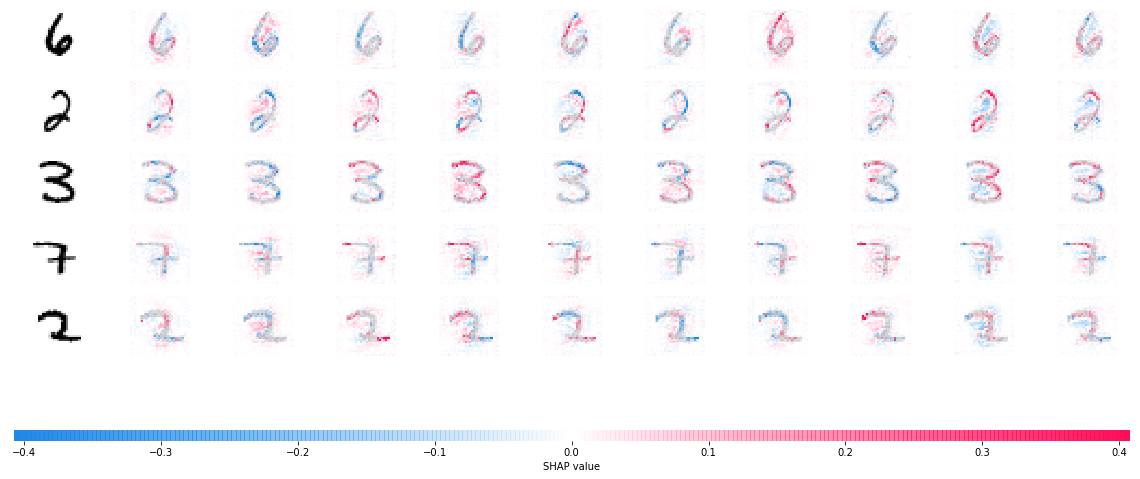

In [20]:
plot.image_plot(shap_values, -test_data[:5])